# Imports

In [1]:
from PMP_importlib import measurement as ms
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from glob import glob

# Gather Hall data

First set the independent variables

In [2]:
datafolder = "../data/Hall_anneal/"

doping_list = ['int', 'r96', 'r48', 'r24', 'r16']
doping_type = CategoricalDtype(doping_list, ordered = True)
doping = set(doping_list)

anneal_list = ['asdep'] + [f'{T}C' for T in range(300, 750, 50)]
anneal_type = CategoricalDtype(anneal_list, ordered = True)
anneal = set(anneal_list)

capping = {'cap', 'nocap'}

anneal_type = CategoricalDtype(anneal_list, ordered = True)

Get all possible combinations

In [3]:
index = pd.MultiIndex.from_product([doping, capping, anneal], names = ['doping', 'capping', 'anneal'])
params = pd.DataFrame(index = index).reset_index()

For each combination, was I able to do a measurement?

If not, filter out.


In [4]:
def filter_true(f):
    def wrapped(df):
        return df[df.apply(f, axis = 1)]
    return wrapped

@filter_true
def measurement_valid(x):
    # I was able to measure all capped samples
    if x.capping == 'cap':
        return True
    # handle uncapped samples
    max_temp_nocap = {
        'int' : '300C',
        'r16' : '450C',
        'r24' : '400C',
        'r48' : '400C',
        'r96' : '350C',
    }
    T_max = max_temp_nocap[x.doping]
    # valid anneals include asdep up to maximal annealing temperature
    valid_anneal = {T for T in anneal if T == 'asdep' or T <= T_max}
    return x.anneal in valid_anneal

For these valid measurements, get their filenames.

In [5]:
def set_column(colname):
    def decorator(f):
        def wrapped(df):
            new_df = df.copy()
            new_df[colname] = new_df.apply(f, axis = 1)
            return new_df
        return wrapped
    return decorator

@set_column('filename')
def create_filename(x):
    # derive relevant filename from parameters
    
    # special case : int, cap should be version 2
    if {x.doping, x.capping} == {'int', 'cap'}:
        return '_'.join([x.doping, x.capping, x.anneal, 'no2']) + '.xlsx'
    
    # special case : int, cap should be version 2
    if {x.doping, x.capping} == {'r16', 'cap'}:
        pass
        #return '_'.join([x.doping, x.capping, x.anneal, 'no2']) + '.xlsx'
    
    # otherwise default
    return '_'.join([x.doping, x.capping, x.anneal]) + '.xlsx'

In [6]:
def get_data(x):
    filepath = datafolder + x.filename
    data = ms.HallMeasurement(filepath).asDict()
    data = pd.Series(data).rename({
        'Hall mobility'               : 'mu_H'  , # m^2 V s-1
        'Carrier concentration'       : 'n'     , # m^-3
        'Sheet carrier concentration' : 'n_sh'  , # m^-2
        'Hall coefficient'            : 'R_H'   , # m^3 C^-1
        'Sheet Hall coefficient'      : 'R_H_sh', # m^2 C^-1
        'Resistivity'                 : 'rho'   , # Ohm m
        'Sheet resistivity'           : 'rho_sh', # Ohm sq
        'Hall voltage'                : 'V_H'   , # V
        'Thickness'                   : 'd'     , # nm
    })
    return x.append(pd.Series(data))

In [7]:
import pickle
import os
def get_df(use_cache = True, cache = 'halldata'):
    if use_cache and os.path.exists(cache):
        df = pd.read_pickle(cache)
    else:
        df = params\
        .pipe(measurement_valid)\
        .pipe(create_filename)\
        .apply(get_data, axis = 1)\
        .astype('float', errors = 'ignore')
        df.anneal = df.anneal.astype(anneal_type)
        df.doping = df.doping.astype(doping_type)
        df.to_pickle(cache)
    return df
        
    

In [8]:
df = get_df()

[Text(0, 0.5, 'Hall resistivity $\\frac{m^3}{C}$')]

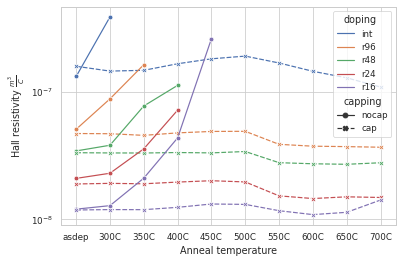

In [24]:
import seaborn as sns

sns.set_theme(
    context = 'paper',
    style = 'whitegrid',
    )

plot_val = 'R_H'
p = sns.lineplot(x = 'anneal', y = plot_val,
                style = 'capping', hue = 'doping',
                markers = True,
                data = df)
p.set(yscale = 'log')
p.set(xlabel = 'Anneal temperature')
p.set(ylabel = 'Hall resistivity $\\frac{m^3}{C}$')

In [10]:
df

,doping,capping,anneal,filename,mu_H,Carrier type,n,n_sh,R_H,R_H_sh,rho,rho_sh,V_H,d
2,r24,nocap,350C,r24_nocap_350C.xlsx,0.000287,N,1.741125e+26,1.567012e+19,3.584756e-08,0.398306,0.000125,1388.805268,-0.000004,90.0
3,r24,nocap,300C,r24_nocap_300C.xlsx,0.001947,N,2.708499e+26,2.437649e+19,2.304416e-08,0.256046,0.000012,131.500937,-0.000026,90.0
5,r24,nocap,asdep,r24_nocap_asdep.xlsx,0.002266,N,2.972495e+26,2.675246e+19,2.099753e-08,0.233306,0.000009,102.949443,-0.000023,90.0
9,r24,nocap,400C,r24_nocap_400C.xlsx,0.000096,N,8.650770e+25,7.785693e+18,7.214972e-08,0.801664,0.000748,8308.502000,-0.000080,90.0
10,r24,cap,550C,r24_cap_550C.xlsx,0.002872,N,4.077620e+26,3.669858e+19,1.530674e-08,0.170075,0.000005,59.227975,-0.000017,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,r16,cap,asdep,r16_cap_asdep.xlsx,0.001462,N,5.265539e+26,4.738985e+19,1.185350e-08,0.131706,0.000008,90.115744,-0.000013,90.0
96,r16,cap,450C,r16_cap_450C.xlsx,0.001856,N,4.725320e+26,4.252788e+19,1.320864e-08,0.146763,0.000007,79.087275,-0.000015,90.0
97,r16,cap,650C,r16_cap_650C.xlsx,0.001901,N,5.491276e+26,4.942148e+19,1.136622e-08,0.126291,0.000006,66.417184,-0.000013,90.0
98,r16,cap,500C,r16_cap_500C.xlsx,0.001828,N,4.757867e+26,4.282081e+19,1.311829e-08,0.145759,0.000007,79.730877,-0.000015,90.0
